In [13]:
import os
import math
import random
import numpy as np
import random
import torch
import models
from models import DeepLab
import draw, utils

In [14]:
os.environ['CUDA_VISIBLE_DEVICES']= '5'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU number: {num_GPU}")
print(f"operation platform: {device}")
    
root_path = os.path.abspath('.')

GPU 数量: 1
运行平台: cuda


In [75]:
dataset_name = "Models"
dataset_path = os.path.join(root_path, "datasets", dataset_name)
                            
samples_train = np.load(os.path.join(dataset_path, 'samples_train.npy'), allow_pickle=True)
samples_valid = np.load(os.path.join(dataset_path, 'samples_valid.npy'), allow_pickle=True)
# print(samples_valid)

print(f'The number of training samples：{len(samples_train)}')
print(f'The number of validation samples：{len(samples_valid)}')

train_sample_path = os.path.join(dataset_path, "Training_dataset")
input_attr_list, output_attr_list,mask_attr_list= ["spns"], ["label"],["mask"]
filter4_attr_list, filter16_attr_list = ["filter4"],["filter16"]


训练样本数量: 1600
验证样本数量: 400


In [76]:
# 定义网络
param_model = {}
param_model['backbone'] = "DeepLab"
param_model['input_channels'] = 1
param_model['output_channels'] = 2

dataset_name = "largescale"
session_name = '-'.join([param_model['backbone'], dataset_name])
# # model = UNet(param_model)
# model = DeepLab(param_model)
model = getattr(models, param_model['backbone'])(param_model)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    model = model.to(device) 
    
# model save ath 
checkpoint_path = os.path.join('checkpoints', session_name)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
print(f"model folder: {checkpoint_path}")

模型读取路径: checkpoints/DeepLab-noconnect-nosmooth


In [77]:
model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'checkpoint-best.pth'))['state_dict'])
samples_test = np.load(os.path.join(dataset_path, 'samples_valid.npy'), allow_pickle=True)
print(f"the numver of test: {len(samples_test)}")

测试样本数量: 400


In [78]:
input_attrs, output_attrs = ["spns"],["label"]
filter4_attrs,filter16_attrs = ["filter4"],["filter16"]

test_sample_path = os.path.join(dataset_path, "Training_datasets")
test_data =  utils.build_dataset(samples_test, test_sample_path,'Train',mask=True, 
                                 input_attr_list=input_attr_list, output_attr_list=output_attr_list,
                                 filter4_attr_list = filter4_attr_list, filter16_attr_list = filter16_attr_list )

In [1]:
idxs = np.random.randint(0, len(test_data), size=6) 
batch_samples = [test_data[i] for i in idxs]
draw_attr_list = ["spns","label","mask"]
draw.draw_samples(batch_samples, draw_attr_list, save=False,cmap=["gray", "jet","jet"], save_file='samples.png')

In [81]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

def pred(model, test_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
    
    model.eval()
    pred_samples = []
    with torch.no_grad():
        for batch_idx, batch_samples in enumerate(test_loader):

#             data = batch_samples['sx']
            for i, input_attr in enumerate(input_attrs):
                tmp = batch_samples[input_attr]
                if i  == 0:
                    data = tmp
                else:
                    data = torch.cat((data, tmp), dim=1)
                    
            for j, filter4_attr in enumerate(filter4_attrs): # filter
                tmp_f4 = batch_samples[filter4_attr]
                if j  == 0:
                    filter4 = tmp_f4
                else:
                    filter4 = torch.cat((filter4, tmp_f4), dim=1)
                    
            for j, filter16_attr in enumerate(filter16_attrs): # filter
                tmp_f16 = batch_samples[filter16_attr]
                if j  == 0:
                    filter16 = tmp_f16
                else:
                    filter16 = torch.cat((filter16, tmp_f16), dim=1)
            
            mask = batch_samples["mask"]
#             print(f"batch_samples['sx']:{data.shape}")
            data = utils.mea_std_norm(data)
    
            data = data.unsqueeze(1)
            filter4 = filter4.unsqueeze(1)
            filter16 = filter16.unsqueeze(1)
            target = batch_samples[output_attrs[0]].long().squeeze(1)

            data, target = data.to(device), target.to(device)
            filter4,filter16 = filter4.to(device),filter16.to(device)
            data, target = Variable(data), Variable(target)
            filter4,filter16 = Variable(filter4),Variable(filter16)
            
            target_i = model(data,filter4,filter16)  
            
            if target_i.shape[1] > 1:
                target_j = F.softmax(target_i, dim=1)
                target_j = torch.argmax(target_j, dim=1, keepdim=True)
            else:
                target_j = torch.sigmoid(target_i[:,:1])
                target_j = utils.threshold_predictions(target_j, thr=0.6)
            
            target_prob = F.softmax(target_i, dim=1)
            target_prob0 = target_prob[:,0,:,:]
            target_prob1 = target_prob[:,1,:,:]
            target_prob0 = target_prob0.unsqueeze(1)
            target_prob1 = target_prob1.unsqueeze(1)
            target_prob0 = target_prob0.cpu().numpy().squeeze(0)
            target_prob1 = target_prob1.cpu().numpy().squeeze(0)
            
            target_j = target_j.cpu().numpy().squeeze(0)
            target = target.cpu().numpy().squeeze(0)
            data = data.cpu().numpy().squeeze(0)
            mask = mask.cpu().numpy().squeeze(0)
            
            batch_samples["pred"] = np.where(target==2,np.nan,target_j)
            batch_samples["data"] = np.where(target==2,np.nan,data)
            batch_samples["label"] = np.where(target==2,np.nan,target)
            batch_samples["prob0"] =  np.where(target==2,np.nan,target_prob0)
            batch_samples["prob1"] =  np.where(target==2,np.nan,target_prob1)
            
            pred_samples.append(batch_samples)
    return pred_samples

pred_samples = pred(model, test_data)
print("done")

done


In [18]:
pred_save_path = os.path.join(dataset_path, "valid_pred")
if not os.path.exists(pred_save_path):
    os.makedirs(pred_save_path)

for i,pred_sample in enumerate(pred_samples):
    pred_sample_file = f'pred_sample_{i}'
    np.save(os.path.join(pred_save_path, pred_sample_file), pred_sample) 

In [2]:
draw.draw_samples(pred_samples[0:5], ["data", "label", "pred"],cmap=["gray", "jet", "jet"],validation=True)

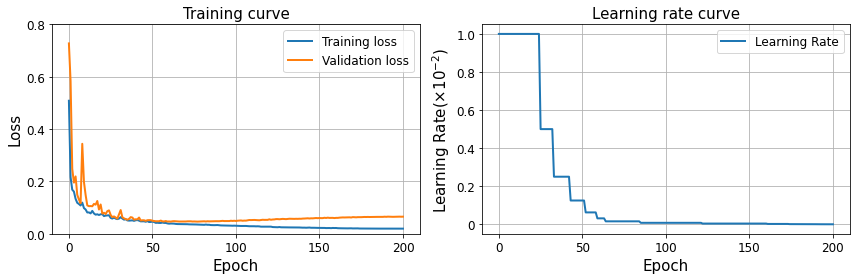

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def smooth(v, w=0.85):
    last = v[0]
    smoothed = []
    for point in v:
        smoothed_val = last * w + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed  


logs = np.load("./checkpoints/DeepLab-largescale/logs.npy",allow_pickle=True)
# print(logs.item())
epoch_loss_train = logs.item()['epoch_loss_train']
epoch_loss_valid = logs.item()['epoch_loss_valid']
epoch_lr = logs.item()['epoch_lr']

x = [i for i in range(201)]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x, smooth(epoch_loss_train, 0.01), label='Training loss', linewidth=2)
ax.plot(x, smooth(epoch_loss_valid, 0.01), label='Validation loss',linewidth=2)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_title(f'Training curve', fontsize=15)
ax.grid(True)
plt.ylim(0.0,0.8)
plt.xticks([0,50,100,150,200],fontsize=12)
plt.yticks([0,0.2,0.4,0.6,0.8],fontsize=12)
plt.legend(loc='upper right', fontsize=12)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x, epoch_lr,  label='Learning Rate',linewidth=2)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Learning Rate($\\times 10^{-2}$)', fontsize=15)
ax.set_title(f'Learning rate curve', fontsize=15)
ax.grid(True)
plt.xticks([0,50,100,150,200],fontsize=12)
plt.yticks([0,0.002,0.004,0.006,0.008,0.010],[0,0.2,0.4,0.6,0.8,1.0],fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
# plt.show()
# plt.savefig("loss.png",bbox_inches='tight',dpi=300)